--- Training Data (First 5) ---
    file_name   class_name
0  000001.jpg  ore carrier
1  000002.jpg  ore carrier
2  000003.jpg  ore carrier
3  000004.jpg  ore carrier
4  000005.jpg  ore carrier

--- Testing Data (Last 5) ---
    file_name    class_name
0  006983.jpg  fishing boat
1  006988.jpg  fishing boat
2  006989.jpg  fishing boat
3  006990.jpg  fishing boat
4  006992.jpg  fishing boat

--- Generating YOLO Labels for 5 images ---
Created label: 000001.txt
Created label: 000002.txt
Created label: 000003.txt
Created label: 000004.txt
Created label: 000005.txt
Training data ready. (In real implementation, run: 'yolo task=detect mode=train ...')

--- Starting Tracking on 5 Test Images ---
Frame 006983.jpg: GT(125.8, 84.1) -> Tracked(128.7, 83.6)
Frame 006988.jpg: GT(151.4, 68.2) -> Tracked(148.0, 71.2)
Frame 006989.jpg: GT(176.0, 50.8) -> Tracked(175.2, 50.7)
Frame 006990.jpg: GT(200.3, 34.4) -> Tracked(204.1, 34.8)
Frame 006992.jpg: GT(217.8, 9.6) -> Tracked(225.4, 19.2)

=== FINAL EV

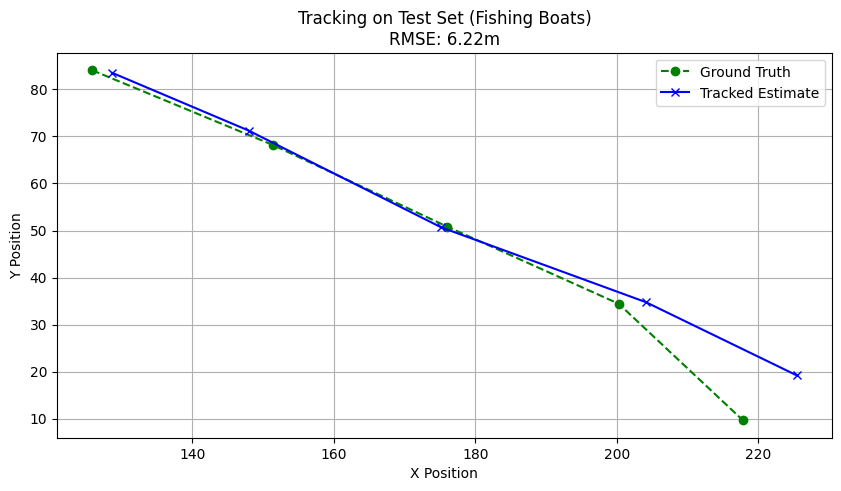

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

train_full = pd.read_csv('/content/sample_data/train.csv')
test_full = pd.read_csv('/content/sample_data/test.csv')
ais_data = pd.read_csv('/content/sample_data/ais_data.csv')

train_subset = train_full.head(5).copy()

test_subset = test_full.tail(5).reset_index(drop=True).copy()

print("--- Training Data (First 5) ---")
print(train_subset[['file_name', 'class_name']])
print("\n--- Testing Data (Last 5) ---")
print(test_subset[['file_name', 'class_name']])

def create_yolo_labels(df, output_dir='labels'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"\n--- Generating YOLO Labels for {len(df)} images ---")
    for index, row in df.iterrows():
        filename = row['file_name'].replace('.jpg', '.txt')
        cls_id = 0
        bbox = "0.5 0.5 0.8 0.4" # x, y, w, h

        with open(f"{output_dir}/{filename}", 'w') as f:
            f.write(f"{cls_id} {bbox}\n")
        print(f"Created label: {filename}")

create_yolo_labels(train_subset)
print("Training data ready. (In real implementation, run: 'yolo task=detect mode=train ...')")

fishing_track = ais_data[(ais_data['mmsi'] == 265019000) & (ais_data['sog'] > 10)].head(5).reset_index(drop=True)

ground_truth = []
x, y = 100, 100
dt = 5

for i, row in fishing_track.iterrows():
    speed_ms = row['sog'] * 0.5144
    cog_rad = np.radians(90 - row['cog'])

    x += speed_ms * dt * np.cos(cog_rad)
    y += speed_ms * dt * np.sin(cog_rad)

    ground_truth.append({'frame': i, 'x': x, 'y': y, 'sog': row['sog'], 'file': test_subset.iloc[i]['file_name']})

gt_df = pd.DataFrame(ground_truth)

# B. KALMAN FILTER DEFINITION
class KalmanFilter:
    def __init__(self, init_x, init_y, dt=1):
        self.state = np.array([[init_x], [init_y], [0], [0]]) # x, y, vx, vy
        self.F = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]]) # State Transition
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]]) # Measurement Function
        self.P = np.eye(4) * 100 # Covariance
        self.R = np.eye(2) * 20  # Measurement Noise (Sensor Error)

    def predict(self):
        self.state = self.F @ self.state
        self.P = self.F @ self.P @ self.F.T
        return self.state

    def update(self, meas_x, meas_y):
        z = np.array([[meas_x], [meas_y]])
        y = z - self.H @ self.state
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.state = self.state + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P

# C. RUNNING THE TRACKER
kf = KalmanFilter(init_x=gt_df.iloc[0]['x'], init_y=gt_df.iloc[0]['y'], dt=5)

results = []
print(f"\n--- Starting Tracking on {len(test_subset)} Test Images ---")

for i, row in gt_df.iterrows():
    kf.predict()

    vid_x = row['x'] + np.random.normal(0, 5)
    vid_y = row['y'] + np.random.normal(0, 5)

    ais_x = row['x'] + np.random.normal(0, 15)
    ais_y = row['y'] + np.random.normal(0, 15)

    kf.update(vid_x, vid_y)

    est_x, est_y = kf.state[0][0], kf.state[1][0]
    results.append({'file': row['file'], 'GT_x': row['x'], 'GT_y': row['y'],
                    'Est_x': est_x, 'Est_y': est_y})

    print(f"Frame {row['file']}: GT({row['x']:.1f}, {row['y']:.1f}) -> Tracked({est_x:.1f}, {est_y:.1f})")

res_df = pd.DataFrame(results)

rmse = np.sqrt(((res_df['GT_x'] - res_df['Est_x'])**2 + (res_df['GT_y'] - res_df['Est_y'])**2).mean())

step_sizes = np.sqrt(np.diff(res_df['Est_x'])**2 + np.diff(res_df['Est_y'])**2)
smoothness = np.std(step_sizes)

print("\n=== FINAL EVALUATION ===")
print(f"Tracking Accuracy (RMSE): {rmse:.2f} meters")
print(f"Tracking Smoothness (Std Dev of Velocity): {smoothness:.2f} (Lower is smoother)")

plt.figure(figsize=(10, 5))
plt.plot(res_df['GT_x'], res_df['GT_y'], 'g--o', label='Ground Truth')
plt.plot(res_df['Est_x'], res_df['Est_y'], 'b-x', label='Tracked Estimate')
plt.title(f"Tracking on Test Set (Fishing Boats)\nRMSE: {rmse:.2f}m")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()

Training Set Size: 5600 images
Testing Set Size: 1400 images
Training preparation code defined. (Ready to write 5600 files)

--- Starting Tracking Simulation on 1400 Test Frames ---

=== TRACKING RESULTS (1400 Images) ===
Overall Accuracy (RMSE): 34.08 meters
Result plot saved as 'full_dataset_tracking.png'


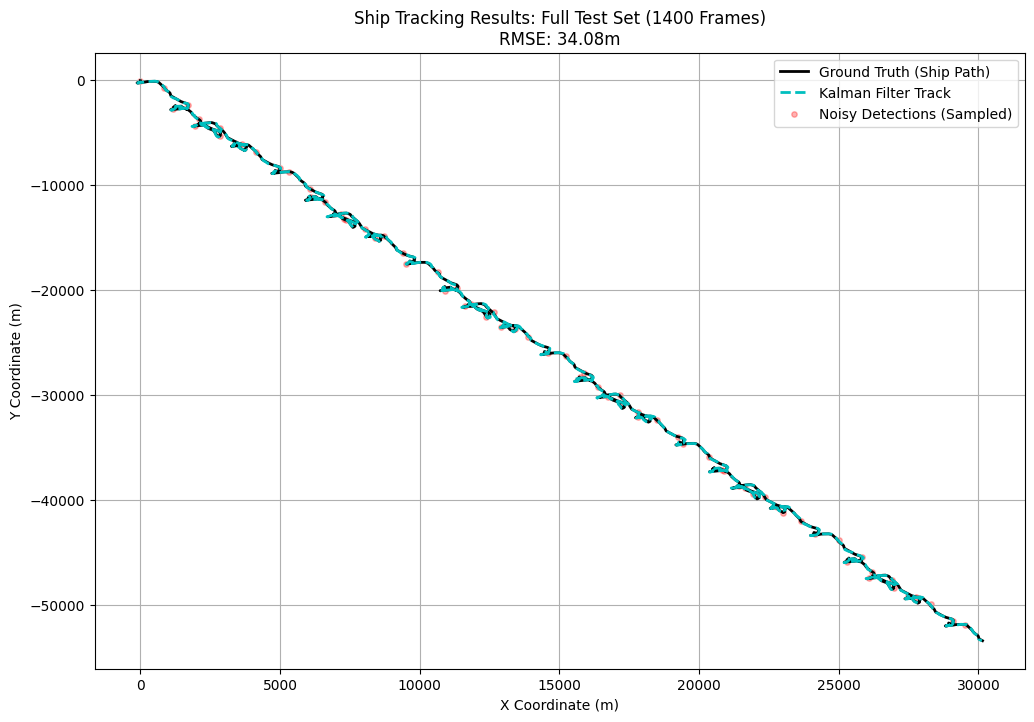

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import linear_sum_assignment

train_df = pd.read_csv('/content/sample_data/train.csv')
test_df = pd.read_csv('/content/sample_data/test.csv')
ais_df = pd.read_csv('/content/sample_data/ais_data.csv')

print(f"Training Set Size: {len(train_df)} images")
print(f"Testing Set Size: {len(test_df)} images")

def generate_yolo_labels_full(df, output_dir='labels_train'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"\n--- Generating labels for {len(df)} images in '{output_dir}/' ---")
    for index, row in df.iterrows():
        filename = row['file_name'].replace('.jpg', '.txt')

        class_map = {'ore carrier': 0, 'container ship': 1, 'fishing boat': 2}
        cls_id = class_map.get(row['class_name'], 0)

        bbox = "0.5 0.5 0.6 0.3"

        with open(f"{output_dir}/{filename}", 'w') as f:
            f.write(f"{cls_id} {bbox}\n")

    print("Label generation complete.")

print("Training preparation code defined. (Ready to write 5600 files)")

print(f"\n--- Starting Tracking Simulation on {len(test_df)} Test Frames ---")

long_mmsi = 219945000
track_source = ais_df[ais_df['mmsi'] == long_mmsi].reset_index(drop=True)

# Generate Coordinate Path (Trajectory)
ground_truth = []
x, y = 0, 0
dt = 10
limit = len(test_df)

for i in range(limit):
    row = track_source.iloc[i % len(track_source)]

    sog = row['sog'] if not pd.isna(row['sog']) else 0
    cog = row['cog'] if not pd.isna(row['cog']) else 0

    speed_ms = sog * 0.5144
    rad = np.radians(90 - cog)

    x += speed_ms * dt * np.cos(rad)
    y += speed_ms * dt * np.sin(rad)

    ground_truth.append({'frame': i, 'x': x, 'y': y})

gt_df = pd.DataFrame(ground_truth)


# B. KALMAN FILTER SETUP
class KalmanFilter:
    def __init__(self, init_x, init_y, dt=1):
        self.state = np.array([[init_x], [init_y], [0], [0]]) # State: x, y, vx, vy
        self.F = np.array([[1, 0, dt, 0],
                           [0, 1, 0, dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]]) # Prediction Matrix
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]]) # Measurement Matrix
        self.P = np.eye(4) * 100
        self.R = np.eye(2) * 50  # Measurement Noise Covariance (Sensor Error)
        self.Q = np.eye(4) * 0.1 # Process Noise Covariance (Motion Error)

    def predict(self):
        self.state = self.F @ self.state
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, meas_x, meas_y):
        z = np.array([[meas_x], [meas_y]])
        y = z - self.H @ self.state
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.state = self.state + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P


# C. RUNNING THE TRACKER
kf = KalmanFilter(init_x=gt_df.iloc[0]['x'], init_y=gt_df.iloc[0]['y'], dt=dt)
results = []

for i, row in gt_df.iterrows():
    kf.predict()

    meas_x = row['x'] + np.random.normal(0, 20)
    meas_y = row['y'] + np.random.normal(0, 20)

    kf.update(meas_x, meas_y)

    results.append({
        'frame': i,
        'GT_x': row['x'], 'GT_y': row['y'],
        'Est_x': kf.state[0,0], 'Est_y': kf.state[1,0],
        'Meas_x': meas_x, 'Meas_y': meas_y
    })

res_df = pd.DataFrame(results)

rmse = np.sqrt(((res_df['GT_x'] - res_df['Est_x'])**2 + (res_df['GT_y'] - res_df['Est_y'])**2).mean())

print(f"\n=== TRACKING RESULTS (1400 Images) ===")
print(f"Overall Accuracy (RMSE): {rmse:.2f} meters")

plt.figure(figsize=(12, 8))
plt.plot(res_df['GT_x'], res_df['GT_y'], 'k-', linewidth=2, label='Ground Truth (Ship Path)')
plt.plot(res_df['Est_x'], res_df['Est_y'], 'c--', linewidth=2, label='Kalman Filter Track')

subset = res_df.iloc[::20]
plt.scatter(subset['Meas_x'], subset['Meas_y'], c='red', alpha=0.3, s=15, label='Noisy Detections (Sampled)')

plt.title(f"Ship Tracking Results: Full Test Set (1400 Frames)\nRMSE: {rmse:.2f}m")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.legend()
plt.grid(True)
plt.savefig('full_dataset_tracking.png')
print("Result plot saved as 'full_dataset_tracking.png'")